# Modelo de segmentación semántica de columnas de humo derivadas de incendios forestales en México

@Autor: Colvert Gomez Rubio

@Dataset: [Kaggle - GOES16-wildfires-smoke-plumes-dataset](https://www.kaggle.com/datasets/colvertgomez/goes16-wildfires-smoke-plumes-dataset)

### Librerías

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.nn import functional
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import cv2
import pandas as pd
import time
from torch.cuda import amp

### GPU ó CPU

In [ ]:
# Verificar si CUDA está disponible y seleccionar el dispositivo correspondiente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Inicializar el escalador de gradientes
scaler = amp.GradScaler()

cuda


### Directorios

In [209]:
 # Definimos la ruta base para nuestro dataset
base_path = os.path.join(os.path.dirname(os.getcwd()) , 'GOES16-wildfires-smoke-plumes-dataset\GOES16-wildfires-smoke-plumes-dataset-1da')

 # Definimos las rutas para los conjuntos de entrenamiento y sus máscaras
train_path = os.path.join(base_path, 'train')
train_masks_path = os.path.join(base_path, 'train_masks')

 # Definimos las rutas para los conjuntos de validación y sus máscaras
valid_path = os.path.join(base_path, 'valid')
valid_masks_path = os.path.join(base_path, 'valid_masks')

 # Definimos las rutas para los conjuntos de prueba y sus máscaras
test_path = os.path.join(base_path, 'test')
test_masks_path = os.path.join(base_path, 'test_masks')

 # Definimos la ruta para la carpeta de modelos, la cual estará en el directorio padre del directorio actual
models_path = (r"C:\Users\colve\OneDrive\Documentos\MEGA\Centro Geo\Tesis\MODELOS")

### Dataset y DataLoader

#### Dataset

In [144]:
class SmokeDataset(Dataset):
    """
    Clase para representar un conjunto de datos de imágenes y máscaras de humo.

    Parámetros:
        images (str): Ruta al directorio que contiene las imágenes.
        masks (str, opcional): Ruta al directorio que contiene las máscaras. Default es None.
        img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes. Default es None.
        mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras. Default es None.

    Atributos:
        images (str): Ruta al directorio que contiene las imágenes.
        masks (str, opcional): Ruta al directorio que contiene las máscaras.
        img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes.
        mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras.
        image_files (list): Lista ordenada de nombres de archivo de las imágenes en el directorio.
        mask_files (list): Lista ordenada de nombres de archivo de las máscaras en el directorio.

    Excepciones:
        AssertionError: Si se proporcionan máscaras, pero el número de imágenes y máscaras no coincide.

    Metodos:
        __len__(): Retorna el número de imágenes en el conjunto de datos.
        __getitem__(idx): Retorna la imagen y su máscara asociada en la posición 'idx'.

    Ejemplo:
        dataset = SmokeDataset(images='/ruta/a/imagenes', masks='/ruta/a/mascaras',
                              img_transforms=transforms.Compose([transforms.Resize((256, 256)),
                                                                transforms.ToTensor()]),
                              mask_transforms=transforms.Compose([transforms.Resize((256, 256)),
                                                                 transforms.ToTensor()]))
        image, mask = dataset[0]

    """

    def __init__(self, images, masks = None, img_transforms = None, mask_transforms = None):
        """
        Constructor de la clase SmokeDataset.

        Parámetros:
            images (str): Ruta al directorio que contiene las imágenes.
            masks (str, opcional): Ruta al directorio que contiene las máscaras. Default es None.
            img_transforms (callable, opcional): Transformaciones a aplicar a las imágenes. Default es None.
            mask_transforms (callable, opcional): Transformaciones a aplicar a las máscaras. Default es None.

        """
        self.images = images
        self.masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Inicializar listas de archivos de imágenes y máscaras
        self.image_files = []
        self.mask_files = []

        # Si se proporcionan máscaras, asegurar que el número de imágenes y máscaras coincida
        if self.masks is not None:
            assert len(os.listdir(self.images)) == len(os.listdir(self.masks)), 'no hay el mismo número de imágenes y máscaras'
            # Obtener lista de archivos de imágenes y máscaras ordenados
            self.image_files = sorted(os.listdir(self.images))
            self.mask_files = sorted(os.listdir(self.masks))
        else:
            # Obtener lista de archivos de imágenes ordenados
            self.image_files = sorted(os.listdir(self.images))

    def __len__(self):
        """
        Método para obtener la cantidad de imágenes en el conjunto de datos.

        Retorna:
            int: Número de imágenes en el conjunto de datos.

        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Método para obtener la imagen y su máscara asociada en la posición 'idx'.

        Parámetros:
            idx (int): Índice de la imagen a obtener.

        Retorna:
            tuple: Tupla con la imagen y su máscara asociada, si las máscaras están disponibles.
                   Si no hay máscaras, retorna solo la imagen.

        """

        image_name = os.path.join(self.images, self.image_files[idx])
        img = Image.open(image_name)
        # Transformar la imagen a tensor
        trans = transforms.ToTensor()

        # Aplicar transformaciones a la imagen si se proporcionan
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        # Si se proporcionan máscaras, obtener y transformar la máscara asociada a la imagen
        if self.masks is not None:
            mask_name = os.path.join(self.masks, self.mask_files[idx])
            mask = Image.open(mask_name)
            # Aplicar transformaciones a la máscara si se proporcionan
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            # Normalizar la máscara
            mask_max = mask.max().item()
            mask /= mask_max
            return img, mask
        else:
            return img

##### Transformaciones

In [145]:
#Definir la transformación de datos
transform_data = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor()])

# Crear el conjunto de datos de entrenamiento
train_dataset = SmokeDataset(train_path, train_masks_path,
                             img_transforms = transform_data,
                             mask_transforms = transform_data)

# Crear el conjunto de datos de validación
val_dataset = SmokeDataset(valid_path, valid_masks_path,
                           img_transforms = transform_data, mask_transforms = transform_data)

# Crear el conjunto de datos de prueba
test_dataset = SmokeDataset(test_path, test_masks_path, 
                            img_transforms = transform_data, mask_transforms = transform_data)

print(f'Número de imágenes de entrenamiento: {len(train_dataset)}, validación: {len(val_dataset)}, prueba:{len(test_dataset)}')

Número de imágenes de entrenamiento: 1462, validación: 207, prueba:123


#### DataLoader

In [146]:
# Tamaño del lote
batch_size =  32

# DataLoader de entrenamiento, validación y prueba
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True)

print(len(train_loader), len(val_loader), len(test_loader))
print(f'Número de mini-lotes de entrenamiento: {len(train_loader)}, validación: {len(val_loader)}, prueba:{len(test_loader)}')

46 7 1
Número de mini-lotes de entrenamiento: 46, validación: 7, prueba:1


### Ploteo de ejemplo

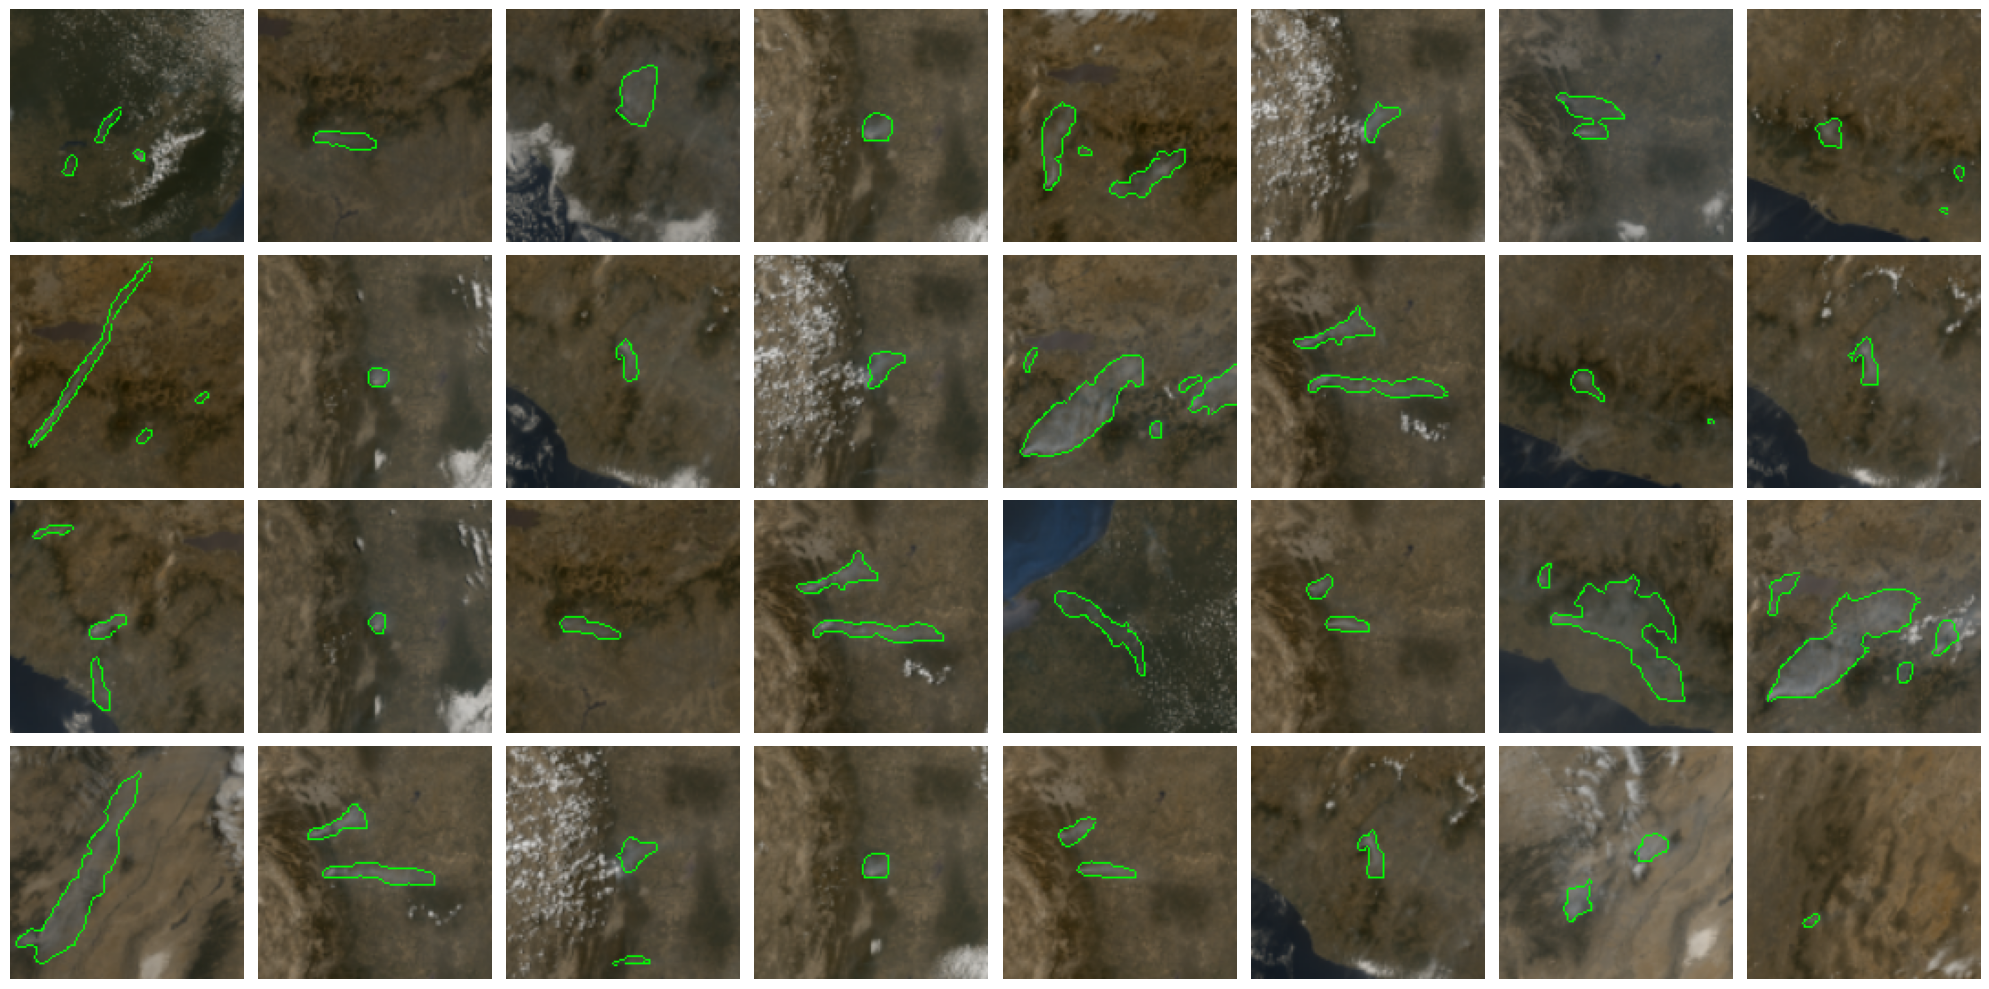

In [147]:
def plot_mini_batch(imgs, masks):
    """
    Función para mostrar una representación visual de un lote de imágenes y sus máscaras asociadas.
    
    Parámetros:
        imgs (torch.Tensor): Tensor que contiene un lote de imágenes con dimensiones (batch_size, channels, height, width).
        masks (torch.Tensor): Tensor que contiene un lote de máscaras con dimensiones (batch_size, channels, height, width).
    
    Retorna:
        None
    
    Ejemplo:
        imgs, masks = next(iter(train_loader))
        plot_mini_batch(imgs, masks)
    """
    plt.figure(figsize=(20, 10))
    # Convertir las imágenes y las máscaras a numpy arrays
    imgs = imgs.permute(0, 2, 3, 1).cpu().numpy()
    masks = masks.permute(0, 2, 3, 1).cpu().numpy()

    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)
        # Obtener la imagen y la máscara correspondiente
        img = imgs[i, ...]
        mask = masks[i, ...]

        # Ajustar los valores de la imagen entre 0 y 1
        img = np.clip(img, 0, 1)

        # Obtener los contornos de la máscara
        contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        # Crear una copia de la imagen con los contornos resaltados en verde
        img_with_contour = img.copy()
        img_with_contour[contour_mask > 0] = [0, 1, 0]

        plt.imshow(img_with_contour)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Obtener un batch de imágenes y máscaras del conjunto de entrenamiento
imgs, masks = next(iter(val_loader))
# Mostrar el batch de imágenes y máscaras
plot_mini_batch(imgs, masks)

### Métricas

In [148]:
def metrics(model, loader):
    """
    Calcula la precisión y otras métricas de evaluación para un modelo dado utilizando un DataLoader.

    Parámetros:
        model (torch.nn.Module): El modelo a evaluar.
        loader (torch.utils.data.DataLoader): DataLoader que contiene los datos de evaluación.

    Retorna:
        tuple: Una tupla que contiene las siguientes métricas de evaluación:
            - val_cost (float): Costo promedio de la función de pérdida (cross_entropy).
            - val_acc (float): Precisión (accuracy) promedio del modelo.
            - dice (float): Coeficiente Dice, una medida de similitud entre las predicciones y las etiquetas reales.
            - iou (float): Índice de Jaccard (IoU), otra medida de similitud para problemas de segmentación.
            - tp (int): True Positives.
            - tn (int): True Negatives.
            - fp (int): False Positives.
            - fn (int): False Negatives.
    """
    cost = 0.0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    model = model.to(device=device)
    # Desactiva el cálculo del gradiente durante la ejecución de este bloque de código
    with torch.no_grad():
        # Itera sobre los datos del cargador
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            with amp.autocast():
                # Calcula las puntuaciones del modelo
                scores = model(x)
                # Calcula el costo utilizando la función de pérdida de entropía cruzada
                cost += functional.cross_entropy(scores, y).item()
                # Calcula las predicciones del modelo
                preds = torch.max(scores, dim=1)[1]

                # Calcula TP, TN, FP, FN
                tp += ((preds == 1) & (y == 1)).sum().item()
                tn += ((preds == 0) & (y == 0)).sum().item()
                fp += ((preds == 1) & (y == 0)).sum().item()
                fn += ((preds == 0) & (y == 1)).sum().item()

    # Calcular las métricas finales
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    iou = (tp) / (tp + fp + fn + 1e-8)
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    val_cost = cost / len(loader)
    
    return val_cost, acc, dice, iou, tp, tn, fp, fn

### Función de entrenamiento

In [149]:
# Crear DataFrame vacío
history_df = pd.DataFrame()

def train(model, optimiser, scheduler = None, epochs = 5, store_every = 1):
    """
    Entrena el modelo utilizando el optimizador especificado durante varias épocas.

    Parámetros:
        model (torch.nn.Module): El modelo a entrenar.
        optimiser (torch.optim.Optimizer): El optimizador utilizado para actualizar los pesos del modelo.
        scheduler (torch.optim.lr_scheduler._LRScheduler, opcional): El programador de tasas de aprendizaje (LR scheduler).
            Por defecto, es None, lo que significa que no se utiliza un programador de tasas de aprendizaje.
        epochs (int, opcional): El número de épocas (iteraciones completas) para entrenar el modelo. Por defecto es 5.
        store_every (int, opcional): Intervalo de épocas para almacenar las métricas. Por defecto es 1.

    Retorna:
        None: La función no devuelve nada, pero entrena el modelo y almacena las métricas en listas globales.
              (train_acc_history, val_acc_history, train_cost_history, val_cost_history, dice_history, iou_history)
    """
    start_time = time.time()  # Obtener el tiempo de inicio del entrenamiento

    model = model.to(device=device)

    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.

        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)

            optimiser.zero_grad()
            with amp.autocast():
                #Calcula las puntuaciones y el coste
                scores = model(x)
                cost = functional.cross_entropy(input=scores, target=y)

            #Realiza un paso de optimización
            scaler.scale(cost).backward()
            scaler.step(optimiser)
            scaler.update()

            # Si se proporciona un programador, se aplica a cada paso de optimización
            if scheduler:
                scheduler.step()

            #Calcula las métricas de entrenamiento
            with torch.no_grad():
                train_predictions = torch.argmax(scores, dim=1)
                train_correct_num += (train_predictions == y).sum()
                train_total += torch.numel(train_predictions)
                train_cost_acum += cost

        # Calcula e imprime las métricas al final de cada época
        if epoch%store_every == 0:
            model.eval()
            train_cost2, train_acc2, train_dice, train_iou, tp, tn, fp, fn = metrics(model, train_loader)
            val_cost, val_acc, val_dice, val_iou, tp, tn, fp, fn = metrics(model, val_loader)

            train_acc = float(train_correct_num) / train_total
            train_cost_every = float(train_cost_acum) / len(train_loader)

            print(f'epoch: {epoch + 1}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                  f' train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                  f' dice train: {train_dice:.4f}, dice val: {val_dice:.4f},'
                  f' iou train: {train_iou:.4f}, iou val: {val_iou:.4f}')

            # Almacena las métricas en el DataFrame
            history_df.loc[epoch, 'epoch'] = epoch + 1

            history_df.loc[epoch, 'train_acc'] = train_acc
            history_df.loc[epoch, 'val_acc'] = val_acc

            history_df.loc[epoch, 'train_cost'] = train_cost_every
            history_df.loc[epoch, 'val_cost'] = val_cost

            history_df.loc[epoch, 'train_dice'] = train_dice
            history_df.loc[epoch, 'val_dice'] = val_dice

            history_df.loc[epoch, 'train_iou'] = train_iou
            history_df.loc[epoch, 'val_iou'] = val_iou


    end_time = time.time()  # Obtener el tiempo de finalización del entrenamiento
    total_time = end_time - start_time  # Calcular el tiempo total de ejecución
    # Convertir el tiempo total a formato horas:minutos:segundos
    total_time_str = time.strftime("%H:%M:%S", time.gmtime(total_time))
    # Imprimir el tiempo total de ejecución en formato horas:minutos:segundos
    print("Tiempo total de ejecución:", total_time_str)

### Modelo UNet

In [150]:
class Conv3k(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa una capa de convolución 2D con kernel de tamaño 3x3, stride de 1 y padding de 1.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        #Capa de convolución
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):
        """
        Realiza una operación de convolución 2D con la entrada dada.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución.
        """
        return self.conv1(x)


class DoubleConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa un bloque de doble convolución seguido de normalización y función de activación LeakyReLU.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv3k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.LeakyReLU(),

                           Conv3k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.LeakyReLU()
                            )

    def forward(self, x):
        """
        Realiza una operación de doble convolución seguida de normalización y LeakyReLU.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la doble convolución.
        """
        return self.double_conv(x)


class DownConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa un bloque de convolución descendente que incluye una capa de MaxPool2D y una DoubleConv.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2, 2),
                        DoubleConv(channels_in, channels_out)
                        )

    def forward(self, x):
        """
        Realiza una operación de convolución descendente con la entrada dada.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución descendente.
        """
        return self.encoder(x)


class UpConv(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        Inicializa un bloque de convolución ascendente que incluye una capa de Upsample, una capa de convolución y una DoubleConv.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels_out (int): Número de canales de salida.
        """
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in // 2, kernel_size = 1, stride = 1)
                        )
        self.decoder = DoubleConv(channels_in, channels_out)

    def forward(self, x1, x2):
        """
        Realiza una operación de convolución ascendente con las entradas dadas.

        Parámetros:
            x1 (torch.Tensor): Tensor de entrada upsampled.
            x2 (torch.Tensor): Tensor de entrada para la concatenación.

        Retorna:
            torch.Tensor: Tensor resultante después de la convolución ascendente.
        """
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)


class Unet(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        """
        Inicializa una arquitectura U-Net que consiste en bloques de convolución descendente y ascendente.

        Parámetros:
            channels_in (int): Número de canales de entrada.
            channels (int): Número de canales para las capas intermedias.
            num_classes (int): Número de clases de salida.
        """
        super().__init__()
        self.first_conv = DoubleConv(channels_in, channels)
        self.down_conv1 = DownConv(channels, 2 * channels)
        self.down_conv2 = DownConv(2 * channels, 4 * channels)
        self.down_conv3 = DownConv(4 * channels, 8 * channels)

        self.middle_conv = DownConv(8 * channels, 16 * channels)

        self.up_conv1 = UpConv(16 * channels, 8 * channels)
        self.up_conv2 = UpConv(8 * channels, 4 * channels)
        self.up_conv3 = UpConv(4 * channels, 2 * channels)
        self.up_conv4 = UpConv(2 * channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size = 1, stride = 1)

    def forward(self, x):
        """
        Realiza una pasada hacia adelante a través de la arquitectura U-Net.

        Parámetros:
            x (torch.Tensor): Tensor de entrada.

        Retorna:
            torch.Tensor: Tensor resultante después de pasar por la U-Net.
        """
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)

### Definición del modelo y entrenamiento

In [151]:
# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Crear el modelo Unet (canales de entrada, convoluciones iniciales, clases de salida)
model = Unet(3, 64, 2)

# Definir el número de épocas
epochs = 20

# Definir el optimizador para el modelo Unet con los parámetros correspondientes
optimiser_unet = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=1e-4)

# Definir el scheduler para el ajuste de la tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, max_lr=1e-1, steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [152]:
train(model, optimiser_unet, scheduler = scheduler, epochs = epochs)

epoch: 1, train cost: 0.1601, val cost: 0.1548, train acc: 0.9477, val acc: 0.9555, dice train: 0.4053, dice val: 0.4139, iou train: 0.2542, iou val: 0.2609
epoch: 2, train cost: 0.0668, val cost: 0.0618, train acc: 0.9739, val acc: 0.9766, dice train: 0.7108, dice val: 0.7382, iou train: 0.5513, iou val: 0.5850
epoch: 3, train cost: 0.0574, val cost: 0.0610, train acc: 0.9772, val acc: 0.9788, dice train: 0.7423, dice val: 0.7851, iou train: 0.5902, iou val: 0.6462
epoch: 4, train cost: 0.0476, val cost: 0.0489, train acc: 0.9806, val acc: 0.9803, dice train: 0.7872, dice val: 0.8222, iou train: 0.6491, iou val: 0.6981
epoch: 5, train cost: 0.0419, val cost: 0.0383, train acc: 0.9829, val acc: 0.9838, dice train: 0.8040, dice val: 0.8315, iou train: 0.6723, iou val: 0.7116
epoch: 6, train cost: 0.0399, val cost: 0.0356, train acc: 0.9834, val acc: 0.9853, dice train: 0.8165, dice val: 0.8493, iou train: 0.6899, iou val: 0.7381
epoch: 7, train cost: 0.0372, val cost: 0.0397, train acc:

### Graficas métricas

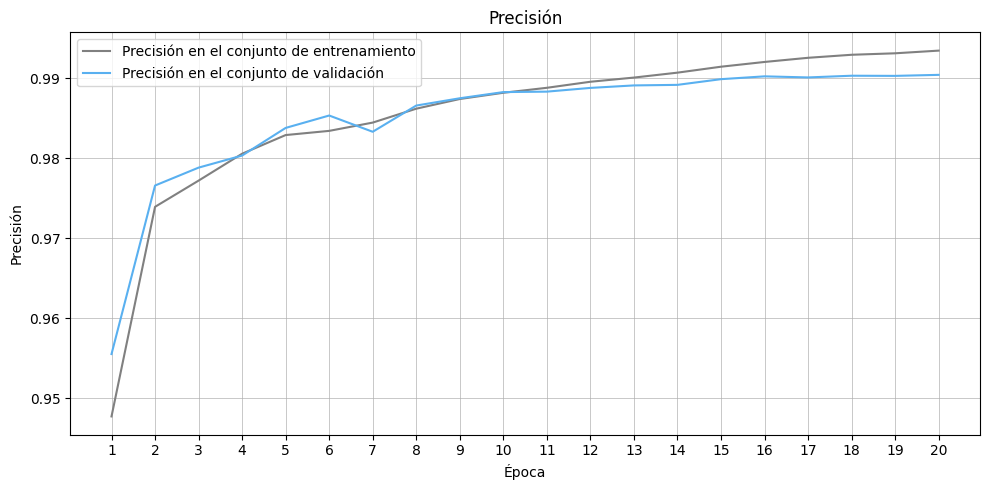

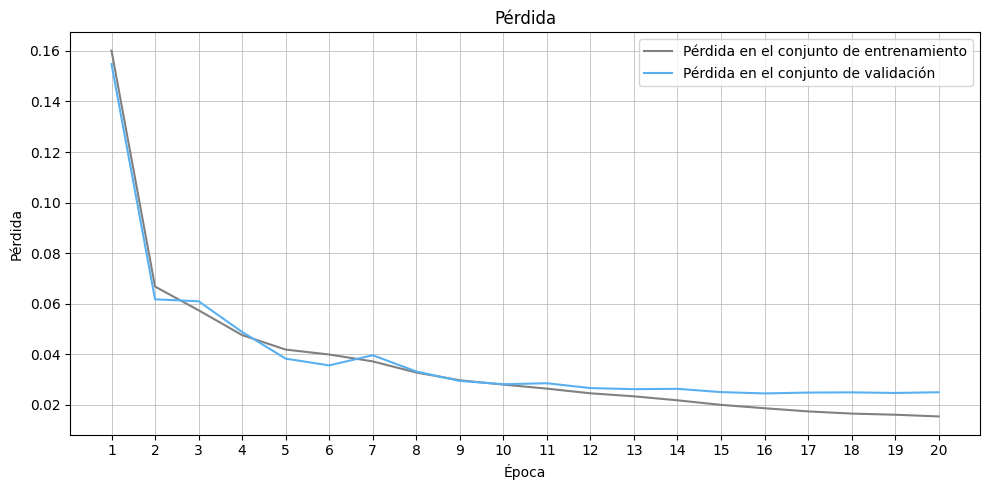

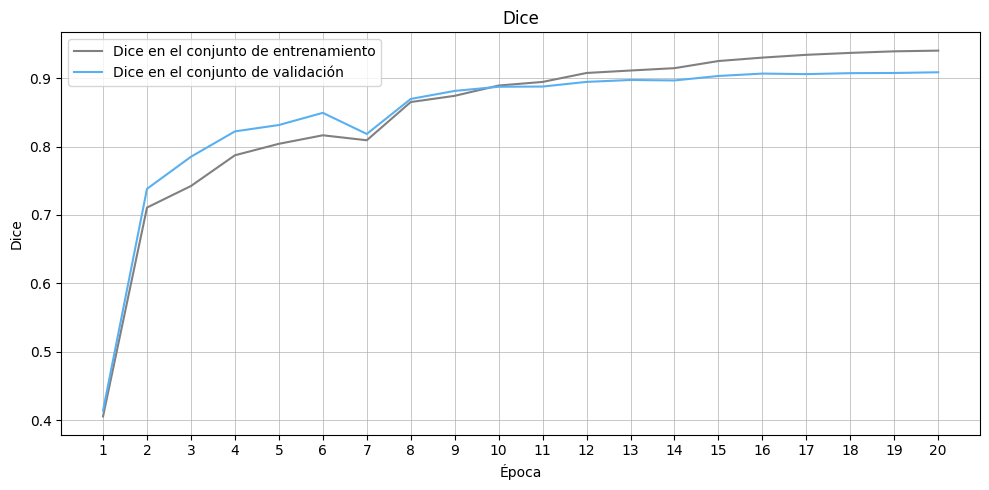

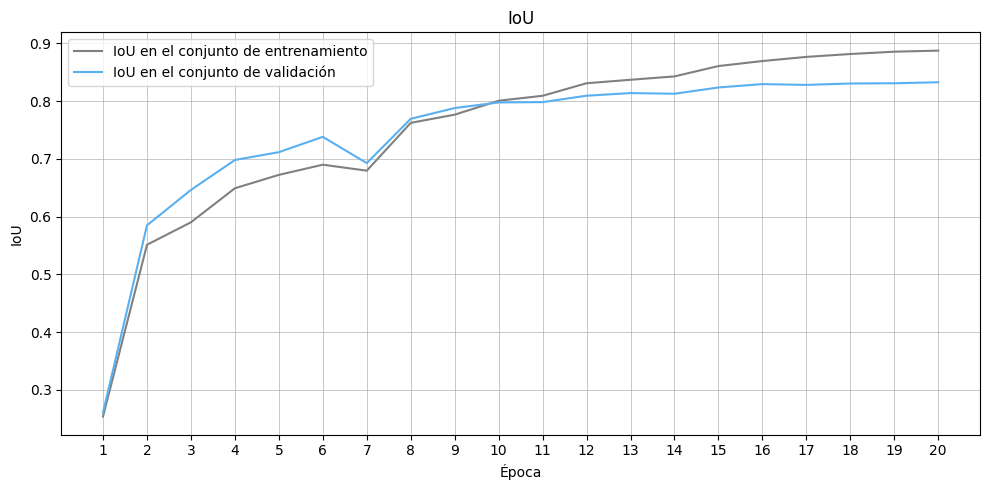

In [219]:
def plot_metrics(history_df, train_label, val_label, y_label, title):
    plt.figure(figsize=(10, 5), dpi = 100)
    plt.plot(history_df["epoch"], history_df[train_label], linestyle='-', color='gray', label=f"{y_label} en el conjunto de entrenamiento")
    plt.plot(history_df["epoch"], history_df[val_label], linestyle='-', color='#59B0F0', label=f"{y_label} en el conjunto de validación")
    plt.xlabel('Época')
    plt.ylabel(y_label)
    plt.xticks(history_df["epoch"])
    plt.title(title)
    plt.grid(True, linestyle='-', linewidth=0.7, alpha=0.7)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_metrics(history_df, "train_acc", "val_acc", "Precisión", "Precisión")
plot_metrics(history_df, "train_cost", "val_cost", "Pérdida", "Pérdida")
plot_metrics(history_df, "train_dice", "val_dice", "Dice", "Dice")
plot_metrics(history_df, "train_iou", "val_iou", "IoU", "IoU")

### Plotea algunas imágenes (validación)

In [162]:
def plot_mini_batch_two(imgs, masks, preds, color_pred, color_true):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)
        img = imgs[i, ...].permute(1, 2, 0).numpy()
        mask = masks[i, ...].permute(1, 2, 0).numpy()
        pred = preds[i, ...].permute(1, 2, 0).numpy()

        # Ajustar los valores de la imagen al rango válido [0, 1]
        img = np.clip(img, 0, 1)

        # Obtener el contorno de la máscara de la predicción
        pred_contour_mask = cv2.Canny(pred[:, :, 0].astype(np.uint8), 0, 1)
        img_with_pred_contour = img.copy()
        img_with_pred_contour[pred_contour_mask > 0] = color_pred  # Pintar el contorno con el color de la predicción

        # Obtener el contorno de la máscara del dato verdadero
        true_contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        img_with_true_contour = img_with_pred_contour.copy()
        img_with_true_contour[true_contour_mask > 0] = color_true  # Pintar el contorno con el color del dato verdadero

        plt.imshow(img_with_true_contour)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


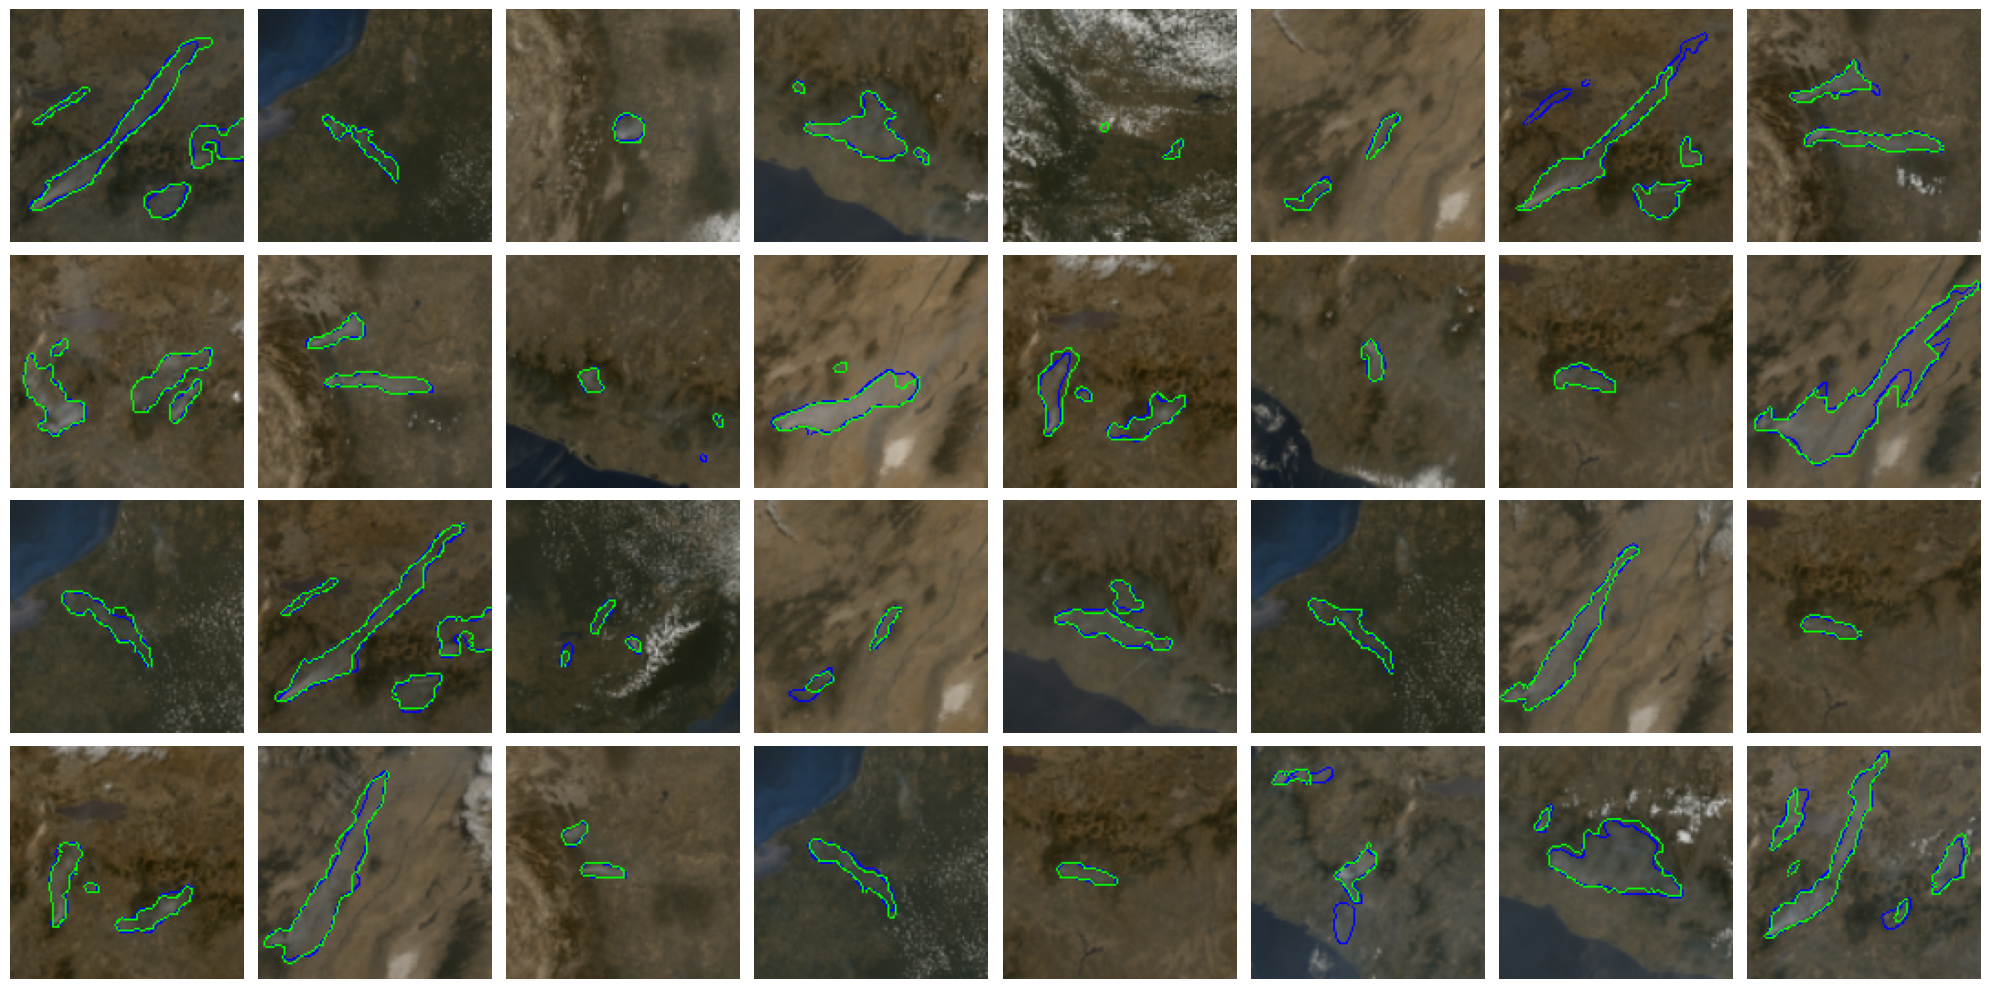

In [163]:
# Código para mostrar la predicción y el dato verdadero juntos
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()

plot_mini_batch_two(imgs_val, masks_val, preds.unsqueeze(1), [0, 0, 1], [0, 1, 0])

### Plotea algunas imágenes (prueba)

In [164]:
def plot_mini_batch_two(imgs, masks, preds, color_pred, color_true):
    plt.figure(figsize=(10, 13), dpi=300)
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        img = imgs[i, ...].permute(1, 2, 0).numpy()
        mask = masks[i, ...].permute(1, 2, 0).numpy()
        pred = preds[i, ...].permute(1, 2, 0).numpy()

        # Ajustar los valores de la imagen al rango válido [0, 1]
        img = np.clip(img, 0, 1)

        # Obtener el contorno de la máscara del dato verdadero
        true_contour_mask = cv2.Canny(mask[:, :, 0].astype(np.uint8), 0, 1)
        img_with_true_contour = img.copy()
        img_with_true_contour[true_contour_mask > 0] = color_true  # Pintar el contorno con el color del dato verdadero

        # Obtener el contorno de la máscara de la predicción
        pred_contour_mask = cv2.Canny(pred[:, :, 0].astype(np.uint8), 0, 1)
        img_with_pred_contour = img_with_true_contour.copy()
        img_with_pred_contour[pred_contour_mask > 0] = color_pred  # Pintar el contorno con el color de la predicción


        plt.imshow(img_with_pred_contour)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


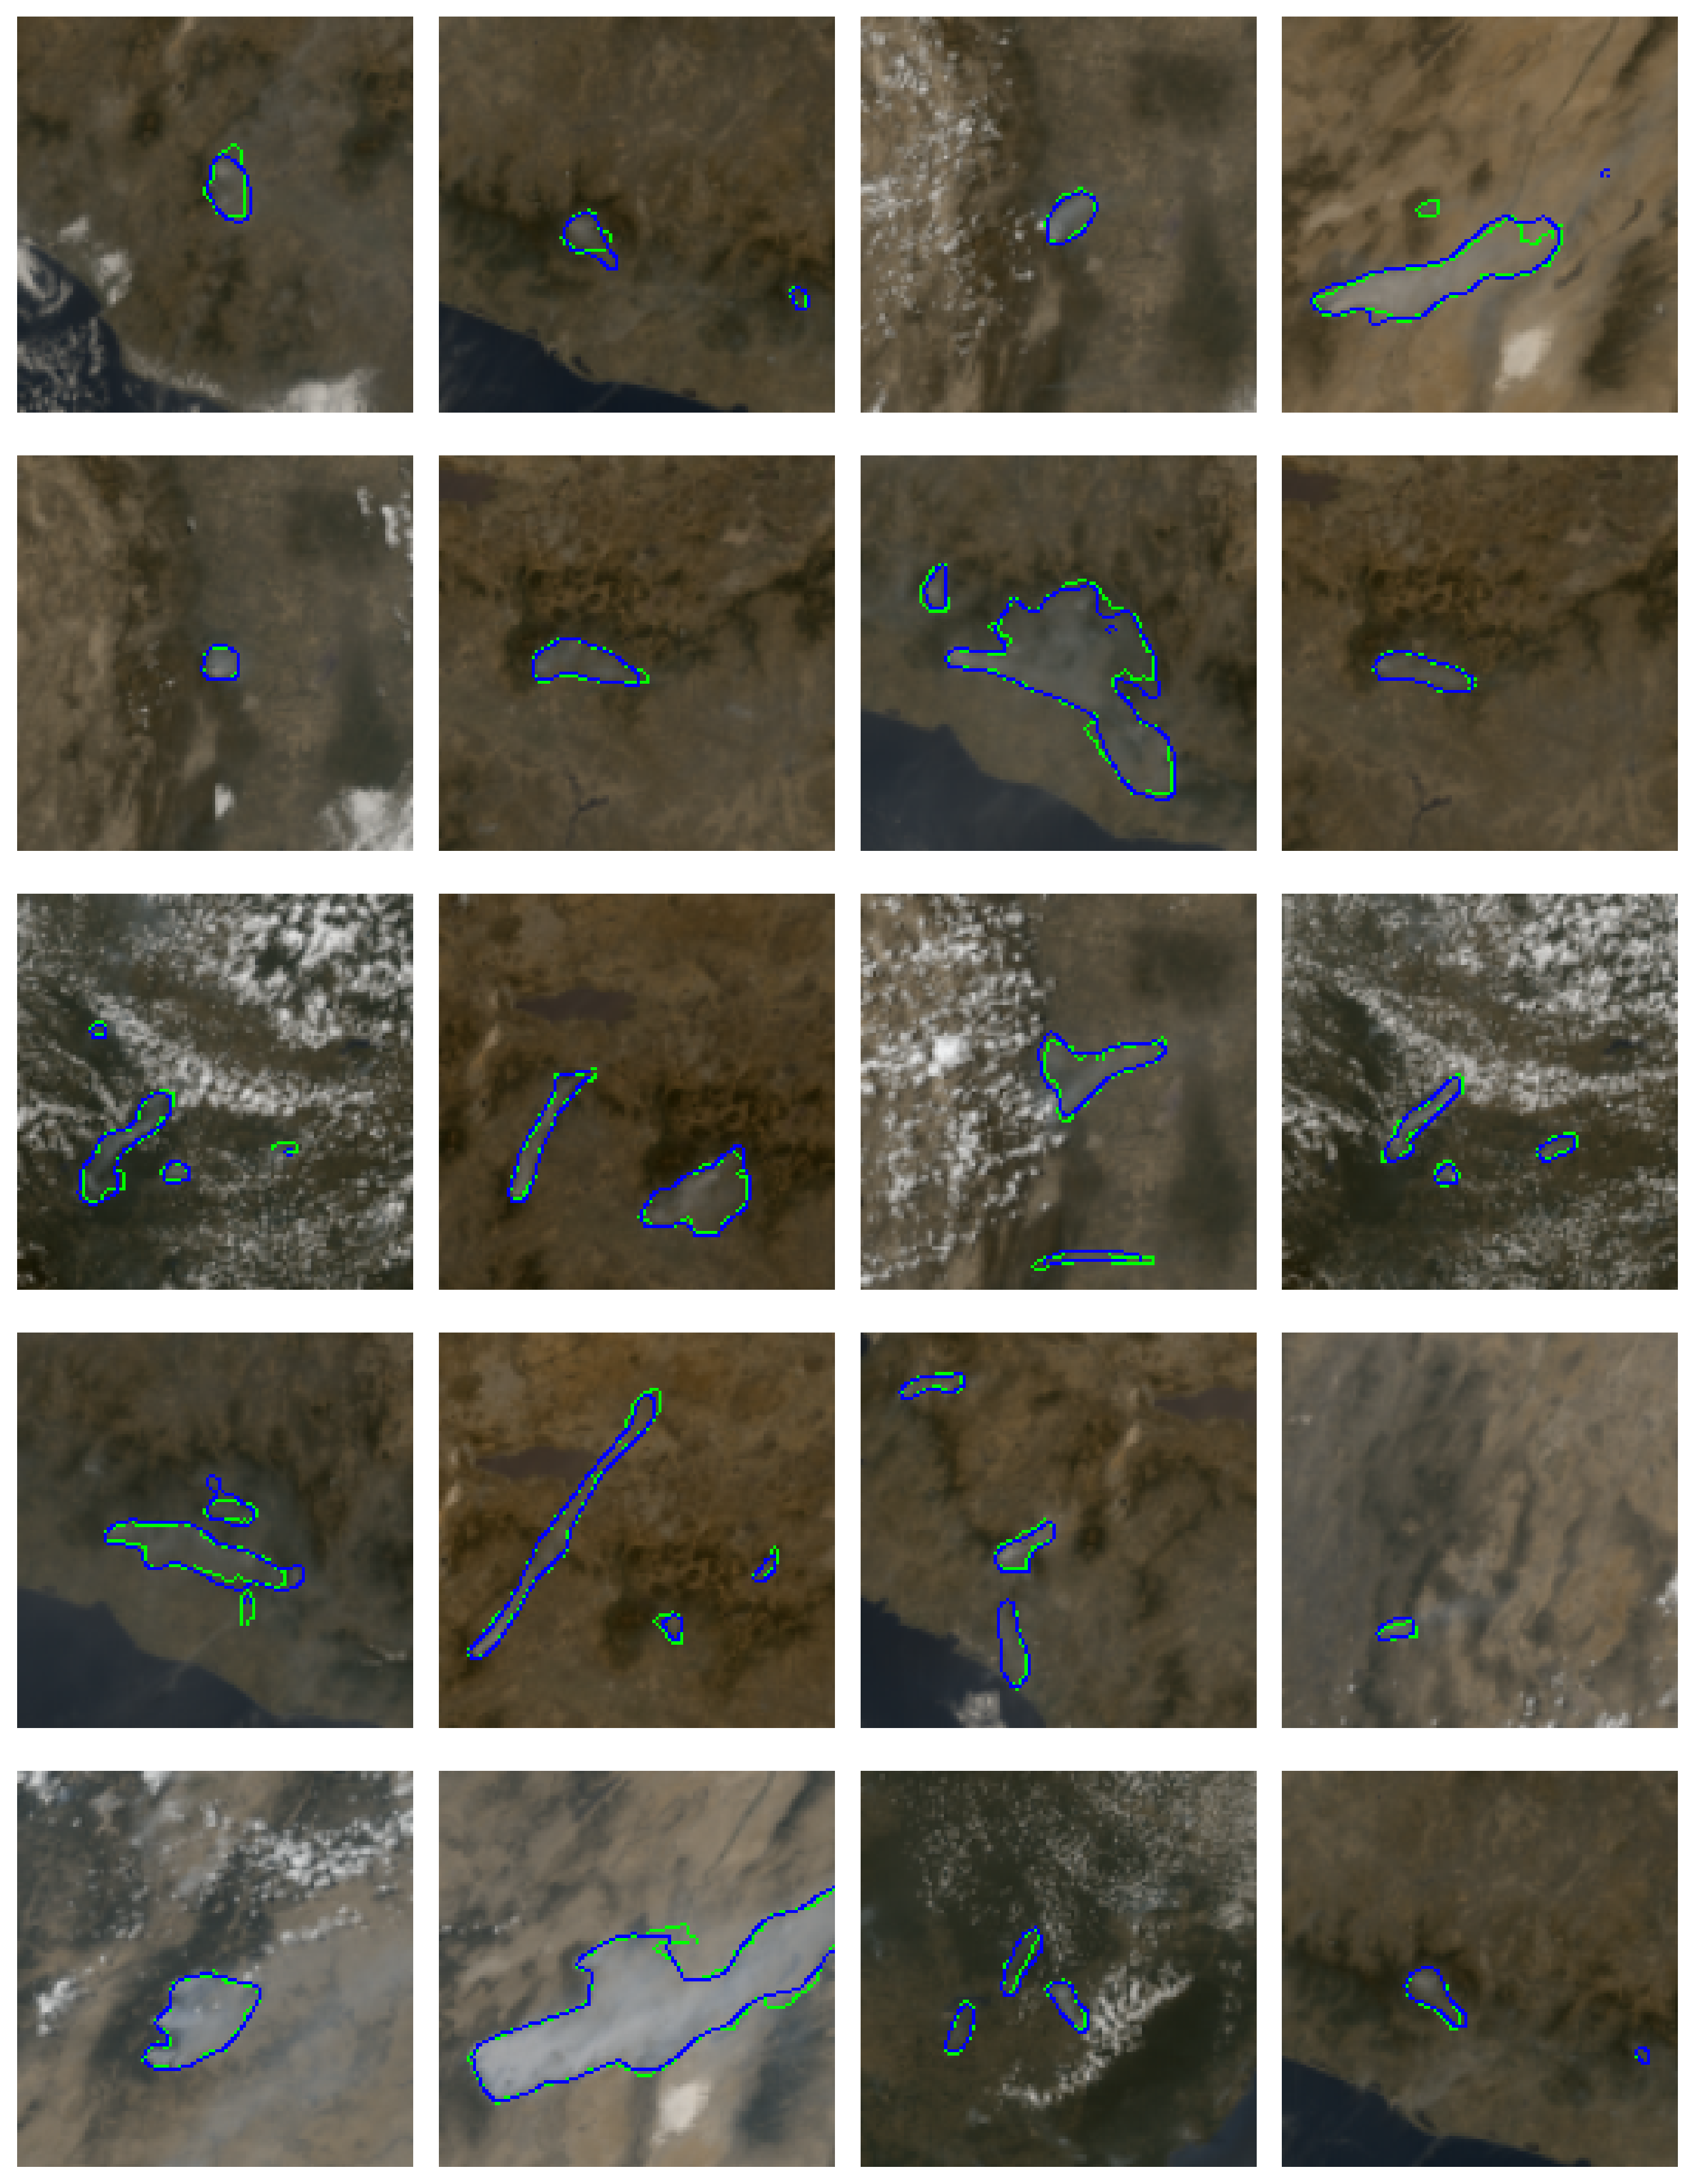

In [165]:
imgs_test, masks_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch_two(imgs_test, masks_test, preds.unsqueeze(1),[0, 0, 1], [0, 1, 0])

### IoU test

In [197]:
cost, acc, dice, iou, tp, tn, fp, fn = metrics(model, test_loader)
print(f'test acc: {acc:.4f}, dice: {dice}, iou: {iou}')
print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn} | Suma: {tp + tn + fp + fn} = 128*128*123 = {128*128*123}')

test acc: 0.9898, dice: 0.9042480421034577, iou: 0.8252305967486432
TP: 97161, TN: 1897494, FP: 9357, FN: 11220 | Suma: 2015232 = 128*128*123 = 2015232


### Matriz de confusión

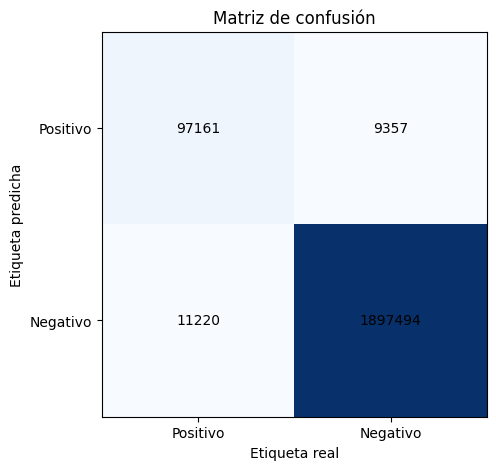

In [218]:
def plot_confusion_matrix(tp, tn, fp, fn):
    # Crear la matriz de confusión
    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    # Configurar el gráfico
    fig, ax = plt.subplots(figsize = (5, 5), dpi = 100)
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Añadir etiquetas a los ejes
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Positivo', 'Negativo'])
    ax.set_yticklabels(['Positivo', 'Negativo'])

    # Añadir valores a las celdas
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha='center', va='center', color='black')

    # Añadir título y etiquetas
    ax.set_title('Matriz de confusión')
    ax.set_xlabel('Etiqueta real')
    ax.set_ylabel('Etiqueta predicha')

    # Mostrar el gráfico
    plt.show()


plot_confusion_matrix(tp, tn, fp, fn)

### Exporta modelo

In [211]:
torch.save(model.state_dict(), models_path + '/unet_columnas_humo_g16_v1_iou8252.pth')